# Base file to edit taken from the finesse website rad pressure example, with some edits
(see setup image)

In [ ]:
# Activate interactive plots
%matplotlib inline

#Import:
# pykat stuff
import pykat
import pykat.ifo.adv as adv
from copy import deepcopy

# Numpy for array manipulation and math functions
import numpy as np

# Matplotlib seaborn and Ipython display for nice plots and tables

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')
matplotlib.rcParams['grid.alpha'] = 0.5
from IPython.display import display
import seaborn as sns

# Multidimensional optical trapping workfile

<img src="./optical_setup.png">
Paper are available here

  * Multidimensional optical trapping of a mirror https://arxiv.org/pdf/1401.6673.pdf 
  * An All-Optical Trap for a Gram-Scale Mirror https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.150802


## End objective:

Simulate multi-dimensional trapping -- base idea: use RP-effects to control suspended mirrors in a stable all optical feedback loop.

   1. plan:
        longitudinal trapping, compare with literature

   2. two possible options :
        "small angle" detuning, use a HG 1-0 subcarrier
        large angle detuning ?? connection with optical dynamcis computation

   3.  bonus: noise analysis




In [ ]:
kat = pykat.finesse.kat()
kat.parse("""

 
l l_main 6 30k n1m # main laser
s s1m 1 n1m n1bs

l l_sc 0.30 0 n1a # detuned "subcarrier" laser
s s1a 1 n1a n4bs

# "combiner" 50/50 BS
bs bs1 0.5 0.5 0 0 n1bs n2bs n3bs n4bs
s s2 1 n3bs n2

# the cavity
m Min 0.9992 0.0008 0 n2 n3
s cav1 1 n3 n4
m Mend 1 0 0 n4 dump # roughly 40kHz detuning 
cav cavity Min n3 Mend n4 
cp cavity x fwhm

# apply mass and longitudinal transfer function to mirrors
tf sus1 1 0 p 1080 1000 # pole at 1Hz, Q=3200
#attr Min mass 1. zmech sus1
attr  Mend mass 0.003 zmech sus1
 
# apply a `force signal' to the end mirror
fsig aforce Mend Fz 1 0
 
# we want to measure the longitudinal motion signal of both mirrors
xd Mend_z Mend z
xd Min_z Min z
 
xaxis aforce f log 0.1 2k 100
x2axis l_sc f lin -100e3 100e3 500  # sub carrier laser frequency sweep
yaxis log abs:deg

""")

In [ ]:
#Input Mirror parameters
Min_T = 8e-4
Min_R = 1-Min_T
#Min_mass = 1. # Kilo disabled

kat.Min.T=Min_T
kat.Min.R=Min_R
#kat.Min.mass=Min_mass


#End Mirror parameters
Mend_T = 0
Mend_R = 1-Mend_T
Mend_mass = 1.e-3 # Kilo disabled


kat.Mend.T=Mend_T
kat.Mend.R=Mend_R
kat.Mend.mass=Mend_mass


In [ ]:
out = kat.run()

In [ ]:
print('Cavity MWHM: {0:3.4} kHz'.format( np.abs(out['cavity_x_fwhm']/2000.)[0,0] ))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
mesh = ax[0].pcolormesh(out.x, out.y, np.abs(-1/(2 * np.pi* out.x * Mend_mass)**2 / out['Mend_z'] -1), norm=matplotlib.colors.LogNorm())
fig.colorbar(mesh,ax=ax[0])

mesh = ax[1].pcolormesh(out.x, out.y, np.unwrap(np.angle(-1/(2 * np.pi* out.x * Mend_mass)**2 / out['Mend_z'] -1)))
fig.colorbar(mesh,ax=ax[1])

for a in ax:
    a.set_xscale('log')

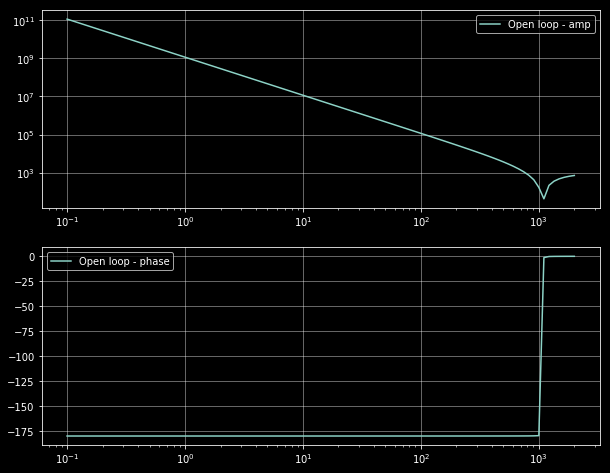

In [173]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

ax[0].loglog(out.x, np.abs(-1/(2 * np.pi* out.x*Mend_mass)**2 / out['Mend_z'][75] -1), label='Open loop - amp')
ax[1].semilogx(out.x, np.unwrap(np.angle(-1/(2 * np.pi* out.x*Mend_mass)**2 / out['Mend_z'][0] -1))/np.pi*180.,label='Open loop - phase')

for a in ax:
    a.grid()
    a.legend()

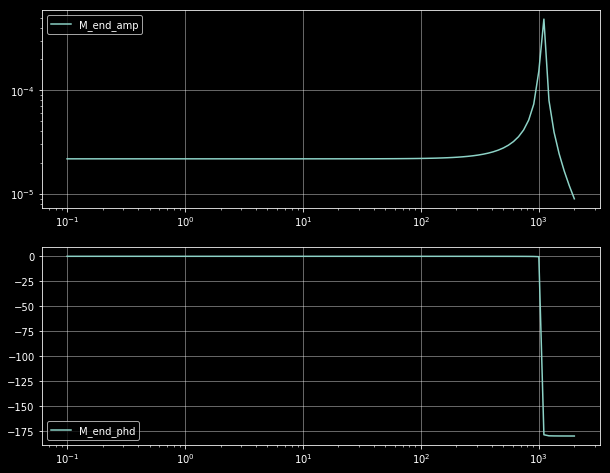

In [174]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].loglog(out.x, np.abs(out['Mend_z'][0]), label="M_end_amp")
ax[1].semilogx(out.x, np.unwrap(np.angle( out['Mend_z'][0] ))/np.pi*180.,label = 'M_end_phd')

for a in ax:
    a.grid()
    a.legend()